In [1]:
import os
import sys

import torch
# from torch import nn, optim
from torch.nn import functional as FeatureAlphaDropout
# import torch.nn as nn
sys.path.append(os.path.realpath('../'))
import numpy as np
# import pickle as pkl
# from datasets import make_dataloader
from bitrap.modeling import make_model
# from bitrap.engine import build_engine

from bitrap.utils.logger import Logger
# import logging
# import argparse
from configs import cfg
from termcolor import colored 
from sort import *

from torch.utils.data import DataLoader
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


c:\Users\sonor\miniconda3\envs\pytorch38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\sonor\miniconda3\envs\pytorch38\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
cfg.merge_from_file("../configs/bitrap_np_JAAD.yml")
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [3]:
model = make_model(cfg)
model = model.to(cfg.DEVICE)
checkpoint = "../" + cfg.CKPT_DIR + "best.pth"

if os.path.isfile(checkpoint):
    model.load_state_dict(torch.load(checkpoint))
    print(colored('Loaded checkpoint:{}'.format(checkpoint), 'blue', 'on_green'))
else:
    print(colored('The cfg.CKPT_DIR id not a file: {}'.format(checkpoint), 'green', 'on_red'))

Loaded checkpoint:../checkpoints/JAAD_checkpoints/goal_cvae_checkpoints/best.pth


In [4]:
images = [f"../data/JAAD/images/video_0005/000{i + 46}.png" for i in range(15)]
yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
mot_tracker = Sort() 


dataloader = DataLoader(images, num_workers=1)
print(len(images))
_min = np.array([0,0,0,0])[None, :]
_max = np.array([1920, 1080, 1920, 1080])[None, :]

Using cache found in C:\Users\sonor/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-11-7 Python-3.8.13 torch-1.12.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


15


In [5]:
def predict(model, input_x, cur_pos = None):
    gt_goal = None
    cur_pos = input_x[:, -1, :cfg.MODEL.DEC_OUTPUT_DIM] if cur_pos is None else cur_pos
    batch_size, seg_len, _ = input_x.shape

    h_x = model.encoder(input_x, None)
    Z, KLD = model.gaussian_latent_net(h_x, input_x[:, -1, :cfg.MODEL.DEC_OUTPUT_DIM], None, z_mode=False)
    enc_h_and_z = torch.cat([h_x.unsqueeze(1).repeat(1, Z.shape[1], 1), Z], dim=-1)
    pred_goal = model.goal_decoder(enc_h_and_z)
    # dec_h = enc_h_and_z if model.cfg.DEC_WITH_Z else h_x

    pred_goal = model.goal_decoder(enc_h_and_z)

    # dec_h = enc_h_and_z if model.cfg.DEC_WITH_Z else h_x
    pred_traj = model.pred_future_traj(h_x, pred_goal)
    cur_pos = input_x[:, -1, :cfg.MODEL.DEC_OUTPUT_DIM] if cur_pos is None else cur_pos.unsqueeze(1)
    pred_goal = pred_goal + cur_pos
    pred_traj = pred_traj + cur_pos.unsqueeze(1)

    return pred_traj, pred_goal



In [32]:
def get_image(imgs):
    results = yolo(imgs)
    overall_data = []
    for j in range(len(results.pandas().xyxy)):
        df = results.pandas().xyxy[j]
        bounding_boxes_pedestrians = df.loc[df['class'] == 0]
        data = []

        # TODO: FOR NOW, break statement exists so it only predicts one person... This will need to change
        for i, row in bounding_boxes_pedestrians.iterrows():
            bbox = np.array([[row['xmin'], row['ymin'], row['xmax'], row['ymax']]])
            bbox[..., [2, 3]] = bbox[..., [2, 3]] - bbox[..., [0, 1]]
            bbox[..., [0, 1]] += bbox[..., [2, 3]]/2
            
            

            # NOTE Normalize bbox
            # W, H  = all_resolutions[i][0]
            # _min comes from MIN_BBOX in config
            # _max comes from MAX_BBOX in config

            bbox = (bbox - _min) / (_max - _min)
            
            data.append(bbox[0])
        overall_data.append(data)
            
            
    overall_data = np.array(overall_data)
    
    # max_val = np.max(np.abs(data))
    # min_val = np.min(data)



    return torch.FloatTensor(overall_data)

In [34]:
%time

model.eval()

input_x = get_image(images)
input_x = input_x.to(cfg.DEVICE)
input_x = input_x.unsqueeze(0)
cur_pos = input_x[:, -1, :cfg.MODEL.DEC_OUTPUT_DIM]
pred_traj, pred_goal = predict(model, input_x, cur_pos=input_x[-1, :cfg.MODEL.DEC_OUTPUT_DIM])
pred_traj = pred_traj.detach().to('cpu').numpy()
pred_goal = pred_goal.detach().to('cpu').numpy()


CPU times: total: 0 ns
Wall time: 0 ns


C:\Users\sonor\AppData\Local\Temp\ipykernel_13960\1617954950.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  overall_data = np.array(overall_data)


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [21]:
pred_goal = pred_goal * (_max - _min) + _min
pred_traj = pred_traj * (_max - _min) + _min

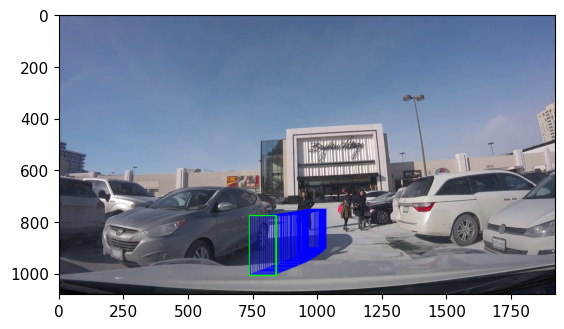

In [25]:
cv_image = cv2.imread(f"../data/JAAD/images/video_0005/00061.png")
for test in pred_traj:
    for j, traj in enumerate(test):
        for i, box in enumerate(traj):
            # if i == len(traj) - 1:
            # rect = cv2.boundingRect(testArray)
            x, y, w, h = int(box[0]), int(box[1]), int(box[2]), int(box[3])
            cv2.rectangle(cv_image, (x, y), (x + w, y + h), (255, 0, 0), 1)
            break

for goal in pred_goal:
    for i, location in enumerate(goal):
        # if i == len(goal) - 1:
        x, y, w, h = int(location[0]), int(location[1]), int(location[2]), int(location[3])
        cv2.rectangle(cv_image, (x, y), (int(x + w) , int(y + h)), (0, 255, 0), 2)
        break

RGB_img = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
plt.show()